In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import cv2
import numpy as np
import os
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**DATA PREPROCESSING**

In [ ]:
def creat_directory(train, test, category):
  if  not os.path.exists(train):
    os.makedirs(train) # Creat test directory
  if  not os.path.exists(test):
    os.makedirs(test) # Create test directory
  if not os.path.exists(os.path.join(train, category)):
    os.makedirs(os.path.join(train, category))
  if not os.path.exists(os.path.join(test, category)):
    os.makedirs(os.path.join(test, category))

In [ ]:
#showing the folders we have in total now

input_dir = '/content/drive/MyDrive/Breast Cancer Data'

os.listdir(input_dir)

['normal', 'benign', 'malignant', 'train', 'test']

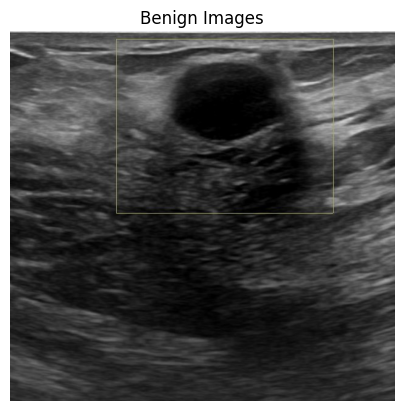

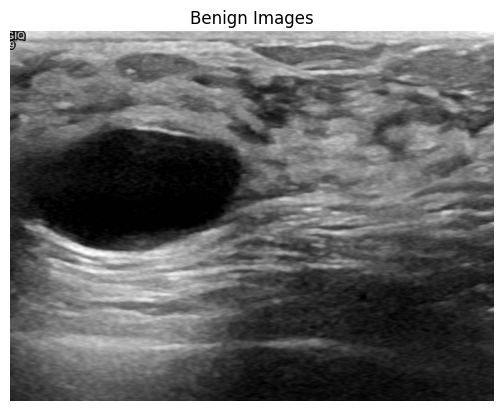

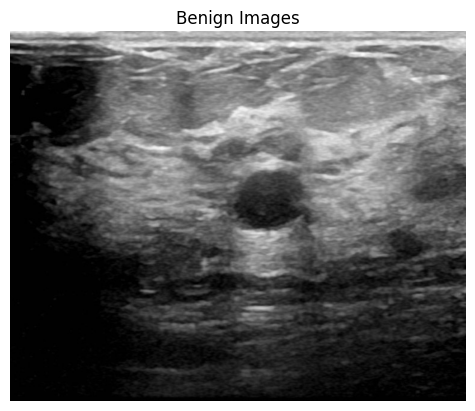

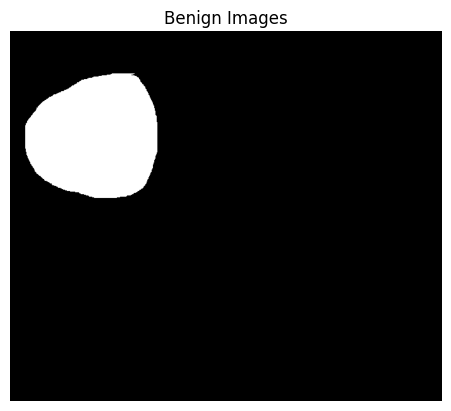

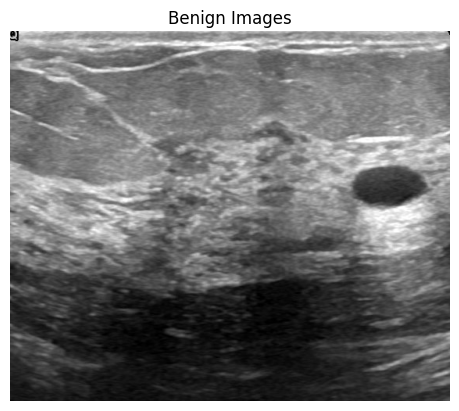

In [ ]:
#preview on the dataset images

def show_images_from_folder(folder_path, num_images=5):
    # Get a list of all image files in the folder
    image_files = [file for file in os.listdir('/content/drive/MyDrive/Breast Cancer Data/benign') if file.endswith(('.jpg', '.jpeg', '.png'))]

    # Display the first `num_images` images
    for i in range(min(num_images, len(image_files))):
        image_path = os.path.join(folder_path, image_files[i])
        image = Image.open(image_path)

        # Show the image
        plt.imshow(image)
        plt.title(f"Benign Images")
        plt.axis('off')
        plt.show()

#showing the images
folder_path = '/content/drive/MyDrive/Breast Cancer Data/benign'
show_images_from_folder(folder_path, num_images=5)


**Checking the sizes of the Images**

In [ ]:
def get_image_sizes(folder_path, max_images=10):
    image_sizes = {}

    # List all files in the folder
    files = os.listdir(folder_path)

    count = 0

    for file in files:
        # Check if the file is an image based on its extension
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            file_path = os.path.join(folder_path, file)
            try:
                # Open the image using PIL
                img = Image.open(file_path)
                # Get the size of the image
                width, height = img.size
                # Add the size information to the dictionary
                image_sizes[file] = (width, height)

                # Increment the count
                count += 1

                # Stop after getting sizes of max_images images
                if count == max_images:
                    break

            except Exception as e:
                # If there is an error in opening the image, print the error message
                print(f"Error reading image {file}: {e}")

    return image_sizes

if __name__ == "__main__":
    folder_path = "/content/drive/MyDrive/Breast Cancer Data/malignant"
    max_images = 10  # Number of images to print sizes for
    image_sizes = get_image_sizes(folder_path, max_images)

    # Print the image sizes
    for filename, size in image_sizes.items():
        print(f"{filename}: {size[0]}x{size[1]}")


malignant (10)_mask.png: 462x393
malignant (1).png: 449x598
malignant (101)_mask.png: 883x559
malignant (100)_mask.png: 557x476
malignant (10).png: 462x393
malignant (1)_mask.png: 449x598
malignant (101).png: 883x559
malignant (100).png: 557x476
malignant (108)_mask.png: 660x459
malignant (107)_mask.png: 576x454


In [ ]:
def get_images(input_dir, category):
  # image directory

  img_dir = os.path.join(input_dir, category)

  # Dedine the percentage of the images to use for testing
  test_percent = 0.1

  # Sanity Check
  image_files = [os.path.join(img_dir, n)for n in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, n)) and n.endswith('.png')]

  # shuffle the images
  random.shuffle(image_files)

  #Calculate the number of images to use for training and testing
  num_images = len(image_files)
  num_test = int(test_percent * num_images)
  num_train = num_images - num_test

  # Creat Paths for Training and Testing
  train_dir = os.path.join(input_dir, 'train')
  test_dir = os.path.join(input_dir, 'test')

  # Create Actual Training and Testing Directories
  creat_directory(train_dir, test_dir, category)

  train_out_dir = os.path.join(train_dir, category)
  test_out_dir = os.path.join(test_dir, category)
  img_names = os.listdir(img_dir)

  # Copy the Image to the training and Testing Directories
  for n in range(num_images):
    img_file = image_files[n]

    current_img_name = img_names[n]
    # read the image
    img = cv2.imread(img_file)
    #resize the image to 224 by 224
    img_res=cv2.resize(img, (224, 224))

    if n < num_train:
      cv2.imwrite(os.path.join(train_out_dir, current_img_name ), img_res)
    else:
      cv2.imwrite(os.path.join(test_out_dir, current_img_name ), img_res)


In [ ]:
categories = os.listdir(input_dir)

for category in categories:
  get_images(input_dir, category)

In [ ]:
# Check the size of the images
def check_imagesize(dir, category):
  cat_path = os.path.join(dir, category)
  images = os.listdir(cat_path)

  for i in range(5):
    img = images[i]
    image = cv2.imread(os.path.join(cat_path, img))
    print(image.shape)

In [ ]:
train_dir = '/content/drive/MyDrive/Breast Cancer Data/train'



In [ ]:
check_imagesize(train_dir, 'benign')

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


**Building Simple CNN Architectures**

In [4]:
#Simple CNN model using adam optimizer

# Define the parameters for Data Augmentation
train_datagen = ImageDataGenerator(rescale= 1.0/255, horizontal_flip=True, vertical_flip=True,
                                   shear_range=0.2, zoom_range = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Define model architectures
model_try1 = Sequential()

#Input Layer
model_try1.add(Conv2D(16, (3,3), padding="same", activation = 'relu', input_shape = (224, 224,3)))
model_try1.add(MaxPooling2D((2,2)))


# Hiden Layer
model_try1.add(Conv2D(32, (3,3), padding="same",  activation = 'relu'))
model_try1.add(MaxPooling2D((2,2)))
model_try1.add(Conv2D(64, (3,3), padding="same", activation = 'relu'))
model_try1.add(MaxPooling2D((2,2)))


#Fully Connected layer
model_try1.add(Flatten())
model_try1.add(Dense(128, activation = 'relu'))
model_try1.add(Dropout(0.5))

#Outer Layer
model_try1.add(Dense(3, activation = 'softmax'))

In [ ]:
model_try1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 64)      

In [ ]:
# Define model checkpoint and aerly stopping
model_filepath = '/content/drive/MyDrive/Breast Cancer Data/Model'
check_point = ModelCheckpoint(os.path.join(model_filepath, 'trial_try1.hdf5'), save_best_only=True)
stopping= EarlyStopping(patience=3)

In [ ]:
# Compile the Model
model_try1.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
from backcall.backcall import callback_prototype
# Train the Network
history_try1 = model_try1.fit(train_generator, steps_per_epoch=train_generator.samples//32, validation_data=test_generator, validation_steps=test_generator.samples //32,
                    epochs = 10, callbacks= [check_point, stopping])

Epoch 1/10
44/44 [==============================] - 28s 623ms/step - loss: 0.9738 - accuracy: 0.5558 - val_loss: 0.8214 - val_accuracy: 0.5859
Epoch 2/10
44/44 [==============================] - 27s 609ms/step - loss: 0.8043 - accuracy: 0.6350 - val_loss: 0.7414 - val_accuracy: 0.6641
Epoch 3/10
44/44 [==============================] - 24s 556ms/step - loss: 0.7433 - accuracy: 0.6724 - val_loss: 0.7367 - val_accuracy: 0.6562
Epoch 4/10
44/44 [==============================] - 22s 510ms/step - loss: 0.7221 - accuracy: 0.6767 - val_loss: 0.7038 - val_accuracy: 0.6719
Epoch 5/10
44/44 [==============================] - 23s 508ms/step - loss: 0.7144 - accuracy: 0.6839 - val_loss: 0.7808 - val_accuracy: 0.6406
Epoch 6/10
44/44 [==============================] - 24s 546ms/step - loss: 0.6820 - accuracy: 0.6969 - val_loss: 0.6219 - val_accuracy: 0.7188
Epoch 7/10
44/44 [==============================] - 25s 572ms/step - loss: 0.6685 - accuracy: 0.6962 - val_loss: 0.5986 - val_accuracy: 0.7109

In [ ]:
loss_try1 = history_try1.history['loss']



In [ ]:
val_loss_try1 = history_try1.history['val_loss']



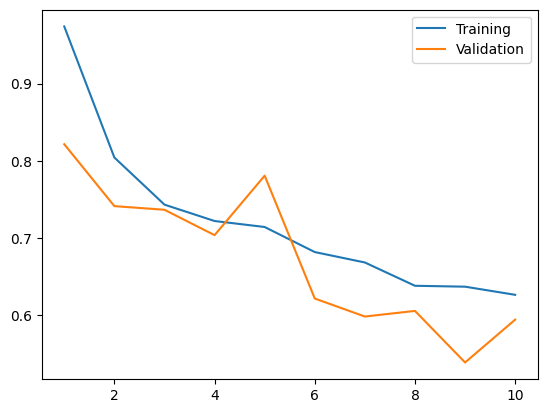

In [ ]:
epochs_try1 = range(1, len(loss_try1) + 1)

plt.plot(epochs_try1, loss_try1, label = 'Training')
plt.plot(epochs_try1, val_loss_try1, label = 'Validation')
plt.legend(loc = 'best')
plt.show()

In [ ]:
# using adam with learning rate 0.0001

adam = Adam(learning_rate=0.0001)

In [ ]:
# simple CNN model using SGD optimizer

# Define the parameters for Data Augmentation
train_datagen = ImageDataGenerator(rescale= 1.0/255, horizontal_flip=True, vertical_flip=True,
                                   shear_range=0.2, zoom_range = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Define model architectures
model_try2 = Sequential()

#Input Layer
model_try2.add(Conv2D(16, (3,3), padding="same", activation = 'relu', input_shape = (224, 224,3)))
model_try2.add(MaxPooling2D((2,2)))


# Hiden Layer
model_try2.add(Conv2D(32, (3,3), padding="same",  activation = 'relu'))
model_try2.add(MaxPooling2D((2,2)))
model_try2.add(Conv2D(64, (3,3), padding="same", activation = 'relu'))
model_try2.add(MaxPooling2D((2,2)))


#Fully Connected layer
model_try2.add(Flatten())
model_try2.add(Dense(128, activation = 'relu'))
model_try2.add(Dropout(0.5))

#Outer Layer
model_try2.add(Dense(3, activation = 'softmax'))

In [ ]:
# Define model checkpoint and aerly stopping
model_filepath = '/content/drive/MyDrive/Breast Cancer Data/Model'
check_point = ModelCheckpoint(os.path.join(model_filepath, 'trial_try2.hdf5'), save_best_only=True)
stopping= EarlyStopping(patience=3)

In [ ]:
#defining the Stochastic Gradient Descent parameters

learning_rate = 0.01
momentum = 0.9
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

# Compile the model with the SGD optimizer
model_try2.compile(optimizer=sgd_optimizer,
              loss='categorical_crossentropy',  # Change this based on your task
              metrics=['accuracy'])

In [ ]:
history_try2 = model_try2.fit(train_generator, steps_per_epoch=train_generator.samples//32, validation_data=test_generator, validation_steps=test_generator.samples //32,
                    epochs = 10, callbacks= [check_point, stopping])

Epoch 1/10
44/44 [==============================] - 22s 464ms/step - loss: 0.9918 - accuracy: 0.5479 - val_loss: 0.9560 - val_accuracy: 0.5703
Epoch 2/10
44/44 [==============================] - 26s 597ms/step - loss: 0.9610 - accuracy: 0.5767 - val_loss: 0.9029 - val_accuracy: 0.5781
Epoch 3/10
44/44 [==============================] - 22s 499ms/step - loss: 0.9130 - accuracy: 0.5731 - val_loss: 0.9084 - val_accuracy: 0.5547
Epoch 4/10
44/44 [==============================] - 23s 526ms/step - loss: 0.8910 - accuracy: 0.5803 - val_loss: 0.8568 - val_accuracy: 0.6328
Epoch 5/10
44/44 [==============================] - 22s 498ms/step - loss: 0.8409 - accuracy: 0.6076 - val_loss: 0.7653 - val_accuracy: 0.6562
Epoch 6/10
44/44 [==============================] - 22s 505ms/step - loss: 0.7824 - accuracy: 0.6623 - val_loss: 0.7887 - val_accuracy: 0.6797
Epoch 7/10
44/44 [==============================] - 21s 467ms/step - loss: 0.7350 - accuracy: 0.6753 - val_loss: 0.7924 - val_accuracy: 0.6172

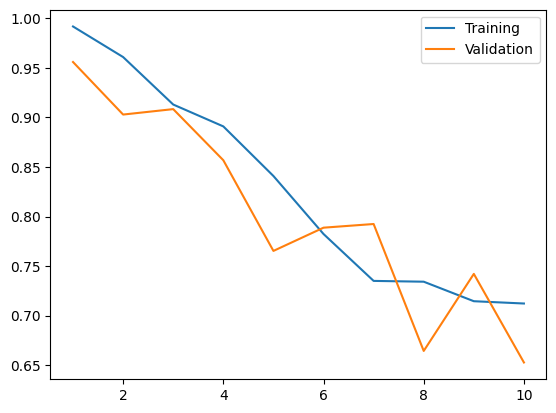

In [ ]:
loss_try2 = history_try2.history['loss']
val_loss_try2 = history_try2.history['val_loss']


epochs_try2 = range(1, len(loss_try2) + 1)

plt.plot(epochs_try2, loss_try2, label = 'Training')
plt.plot(epochs_try2, val_loss_try2, label = 'Validation')
plt.legend(loc = 'best')
plt.show()

CNN BASE-LINE MODEL ARCHITECTURE


In [8]:
# Define the parameters for Data Augmentation
train_datagen = ImageDataGenerator(rescale= 1.0/255, horizontal_flip=True, vertical_flip=True,
                                   shear_range=0.2, zoom_range = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Define model architectures
model1 = Sequential()

#Input Layer
model1.add(Conv2D(32, (3,3), padding="same", activation = 'relu', input_shape = (224, 224,3)))
model1.add(MaxPooling2D((2,2)))


# Hiden Layer
model1.add(Conv2D(64, (3,3), padding="same",  activation = 'relu'))
model1.add(MaxPooling2D((2,2)))
model1.add(Conv2D(64, (3,3), padding="same",  activation = 'relu'))
model1.add(MaxPooling2D((2,2)))
model1.add(Conv2D(128, (3,3), padding="same", activation = 'relu'))
model1.add(MaxPooling2D((2,2)))
model1.add(Conv2D(64, (3,3), padding="same",  activation = 'relu'))
model1.add(MaxPooling2D((2,2)))

#Fully Connected layer
model1.add(Flatten())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.5))

#Outer Layer
model1.add(Dense(3, activation = 'softmax'))

In [5]:
# Define Training and Testing distionary
train_dir = '/content/drive/MyDrive/Breast Cancer Data/train'
test_dir = '/content/drive/MyDrive/Breast Cancer Data/test'

train_generator = train_datagen.flow_from_directory(train_dir,target_size=(224, 224), batch_size=32)

test_generator = test_datagen.flow_from_directory(test_dir,target_size=(224, 224), batch_size=32)

Found 1436 images belonging to 3 classes.
Found 158 images belonging to 3 classes.


In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [6]:
# Define model checkpoint and aerly stopping
model_filepath = '/content/drive/MyDrive/Breast Cancer Data/Model'
check_point = ModelCheckpoint(os.path.join(model_filepath, 'trial1.hdf5'), save_best_only=True)
stopping= EarlyStopping(patience=3)

In [9]:
# Compile the Model
model1.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])

In [10]:
from backcall.backcall import callback_prototype
# Train the Network
history1 = model1.fit(train_generator, steps_per_epoch=train_generator.samples//32, validation_data=test_generator, validation_steps=test_generator.samples //32,
                    epochs = 10, callbacks= [check_point, stopping])

Epoch 1/10
44/44 [==============================] - 665s 15s/step - loss: 0.9118 - accuracy: 0.5491 - val_loss: 0.8258 - val_accuracy: 0.5625
Epoch 2/10
44/44 [==============================] - 24s 542ms/step - loss: 0.8216 - accuracy: 0.6225 - val_loss: 0.7683 - val_accuracy: 0.6562
Epoch 3/10
44/44 [==============================] - 22s 504ms/step - loss: 0.7606 - accuracy: 0.6695 - val_loss: 0.6705 - val_accuracy: 0.7031
Epoch 4/10
44/44 [==============================] - 25s 581ms/step - loss: 0.7236 - accuracy: 0.6617 - val_loss: 0.6569 - val_accuracy: 0.6641
Epoch 5/10
44/44 [==============================] - 24s 555ms/step - loss: 0.6978 - accuracy: 0.6717 - val_loss: 0.5885 - val_accuracy: 0.7266
Epoch 6/10
44/44 [==============================] - 22s 494ms/step - loss: 0.6708 - accuracy: 0.6895 - val_loss: 0.6071 - val_accuracy: 0.7188
Epoch 7/10
44/44 [==============================] - 23s 529ms/step - loss: 0.6428 - accuracy: 0.6916 - val_loss: 0.6400 - val_accuracy: 0.6719


In [ ]:
loss1 = history1.history['loss']



In [ ]:
val_loss1 = history1.history['val_loss']



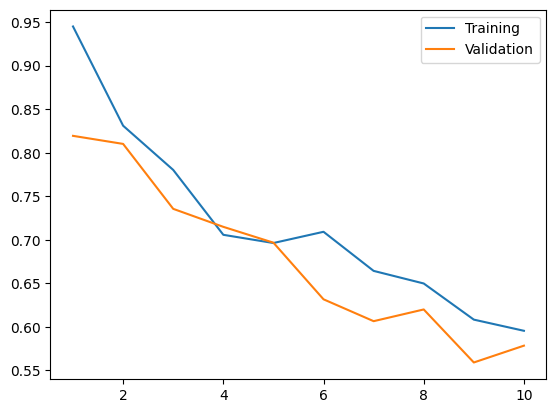

In [ ]:
epochs1 = range(1, len(loss1) + 1)

plt.plot(epochs1, loss1, label = 'Training')
plt.plot(epochs1, val_loss1, label = 'Validation')
plt.legend(loc = 'best')
plt.show()

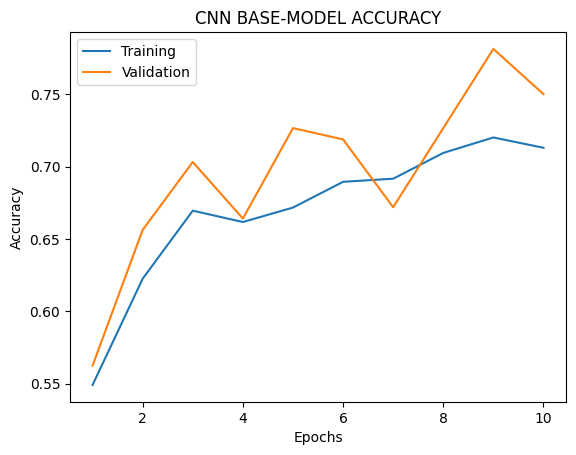

In [32]:
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']

epochs_acc1 = range(1, len(acc1) + 1)

plt.plot(epochs_acc1, acc1, label = 'Training')
plt.plot(epochs_acc1, val_acc1, label = 'Validation')
plt.title('CNN BASE-MODEL ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

**Transfer Learning - Applying pretrained Models**



**USING PRETRAINED VGG16 NETWORK**

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [13]:
train_datagen2=ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen2=ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
batch_size = 32
train_generator2=train_datagen2.flow_from_directory(train_dir, target_size = (224,224), batch_size=batch_size)
test_generator2=test_datagen2.flow_from_directory(test_dir, target_size = (224,224), batch_size=batch_size)

Found 1436 images belonging to 3 classes.
Found 158 images belonging to 3 classes.


**define the VGG16 model**

In [15]:
#VGG16 Model using ADAM optimizer

base_model = VGG16(include_top = False, input_shape=(224, 224, 3), weights = "imagenet")

#freezing the model
for layer in base_model.layers:
  layer.trainable = False

#Define the architecture
model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(1024, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(512, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(128, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation="softmax"))

58889256/58889256 [==============================] - 2s 0us/step


In [16]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [17]:
model2.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics=['accuracy'])

In [18]:
check_point = ModelCheckpoint(os.path.join(model_filepath, "trial2.hdf5"), save_best_only=True, verbose =1)

In [27]:
history2 = model2.fit(train_generator2, validation_data=test_generator2, epochs=10, batch_size=batch_size, callbacks= [check_point, stopping])

Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 0.9665 - accuracy: 0.7166
Epoch 1: val_loss did not improve from 0.46835
45/45 [==============================] - 9s 191ms/step - loss: 0.9665 - accuracy: 0.7166 - val_loss: 0.5223 - val_accuracy: 0.6899
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 1.0529 - accuracy: 0.6894
Epoch 2: val_loss did not improve from 0.46835
45/45 [==============================] - 8s 166ms/step - loss: 1.0529 - accuracy: 0.6894 - val_loss: 0.5144 - val_accuracy: 0.7215
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 0.8575 - accuracy: 0.7194
Epoch 3: val_loss did not improve from 0.46835
45/45 [==============================] - 8s 185ms/step - loss: 0.8575 - accuracy: 0.7194 - val_loss: 0.4753 - val_accuracy: 0.7278
Epoch 4/10
45/45 [==============================] - ETA: 0s - loss: 0.8468 - accuracy: 0.7416
Epoch 4: val_loss improved from 0.46835 to 0.40637, saving model to /content/drive/MyDrive

**Print Model Results**

In [29]:
loss2 = history2.history['loss']



In [30]:
val_loss2 = history2.history['val_loss']


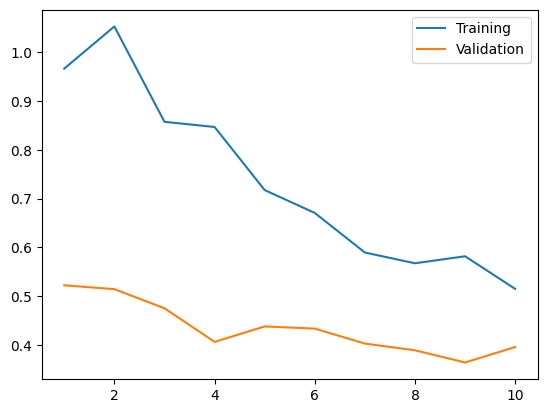

In [31]:
epochs2 = range(1, len(loss2) + 1)

plt.plot(epochs2, loss2, label = 'Training')
plt.plot(epochs2, val_loss2, label = 'Validation')
plt.legend(loc = 'best')
plt.show()

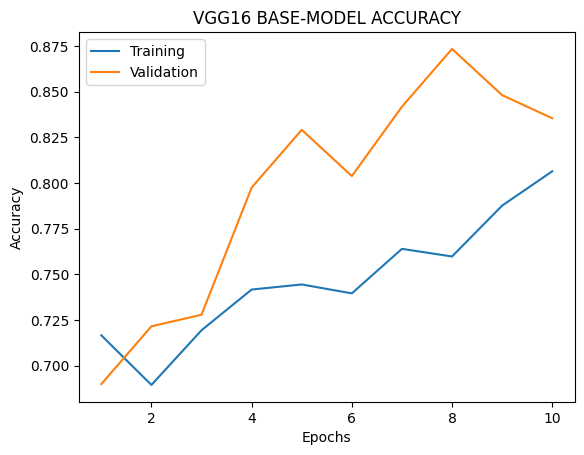

In [28]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

epochs_acc2 = range(1, len(acc2) + 1)

plt.plot(epochs_acc2, acc2, label = 'Training')
plt.plot(epochs_acc2, val_acc2, label = 'Validation')
plt.title('VGG16 BASE-MODEL ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

In [ ]:
#VGG16 Model using SGD optimizer

base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights="imagenet")

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the custom architecture
model2_sgd = Sequential()
model2_sgd.add(base_model)
model2_sgd.add(Flatten())
model2_sgd.add(Dense(1024, activation="relu"))
model2_sgd.add(Dropout(0.5))
model2_sgd.add(Dense(512, activation="relu"))
model2_sgd.add(Dropout(0.5))
model2_sgd.add(Dense(128, activation="relu"))
model2_sgd.add(Dropout(0.5))

model2_sgd.add(Dense(64, activation="relu"))
model2_sgd.add(Dropout(0.5))
model2_sgd.add(Dense(3, activation="softmax"))

# Compile the model with SGD optimizer
from tensorflow.keras.optimizers import SGD

sgd_optimizer = SGD(learning_rate=0.001, momentum=0.9)  # You can adjust the learning rate and momentum
model2_sgd.compile(optimizer=sgd_optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
check_point2_sgd = ModelCheckpoint(os.path.join(model_filepath, "trial2_sgd.hdf5"), save_best_only=True, verbose =1)

In [ ]:
history2_sgd = model2_sgd.fit(train_generator2, validation_data=test_generator2, epochs=10, batch_size=batch_size, callbacks= [check_point2_sgd, stopping])

Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 7.2263 - accuracy: 0.4492
Epoch 1: val_loss improved from inf to 0.86436, saving model to /content/drive/MyDrive/Breast Cancer Data/Model/trial2_sgd.hdf5
45/45 [==============================] - 16s 307ms/step - loss: 7.2263 - accuracy: 0.4492 - val_loss: 0.8644 - val_accuracy: 0.5633
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 1.4601 - accuracy: 0.3733
Epoch 2: val_loss did not improve from 0.86436
45/45 [==============================] - 7s 163ms/step - loss: 1.4601 - accuracy: 0.3733 - val_loss: 0.9984 - val_accuracy: 0.5633
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 1.0800 - accuracy: 0.5216
Epoch 3: val_loss did not improve from 0.86436
45/45 [==============================] - 9s 200ms/step - loss: 1.0800 - accuracy: 0.5216 - val_loss: 1.0368 - val_accuracy: 0.5633
Epoch 4/10
45/45 [==============================] - ETA: 0s - loss: 1.0226 - accuracy: 0.5487
Epoch 4:

**BUILDING PRE-TRAINED RESNET**

In [22]:
#RESNET USING SGD OPTIMIZER

from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD

# Create the base model (ResNet50)
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights="imagenet")

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the custom architecture
model4_try1 = Sequential()
model4_try1.add(base_model)
model4_try1.add(Flatten())
model4_try1.add(Dense(1024, activation="relu"))
model4_try1.add(Dropout(0.5))
model4_try1.add(Dense(3, activation="softmax"))

# Compile the model with SGD optimizer
sgd_optimizer = SGD(learning_rate=0.001, momentum=0.9)
model4_try1.compile(optimizer=sgd_optimizer, loss="categorical_crossentropy", metrics=['accuracy'])


94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
check_point4_try1 = ModelCheckpoint(os.path.join(model_filepath, "trial4_try1.hdf5"), save_best_only=True, verbose =1)
history4_try1 = model4_try1.fit(train_generator2, validation_data=test_generator2, epochs=10, batch_size=batch_size, callbacks= [check_point4_try1, stopping])

Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 3.3426 - accuracy: 0.7833
Epoch 1: val_loss improved from inf to 1.32971, saving model to /content/drive/MyDrive/Breast Cancer Data/Model/trial4_try1.hdf5
45/45 [==============================] - 31s 584ms/step - loss: 3.3426 - accuracy: 0.7833 - val_loss: 1.3297 - val_accuracy: 0.8471
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 1.3014 - accuracy: 0.8628
Epoch 2: val_loss did not improve from 1.32971
45/45 [==============================] - 9s 208ms/step - loss: 1.3014 - accuracy: 0.8628 - val_loss: 1.8196 - val_accuracy: 0.8025
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 0.7489 - accuracy: 0.9057
Epoch 3: val_loss improved from 1.32971 to 0.35555, saving model to /content/drive/MyDrive/Breast Cancer Data/Model/trial4_try1.hdf5
45/45 [==============================] - 20s 437ms/step - loss: 0.7489 - accuracy: 0.9057 - val_loss: 0.3555 - val_accuracy: 0.9108
Epoch 4/10
45/

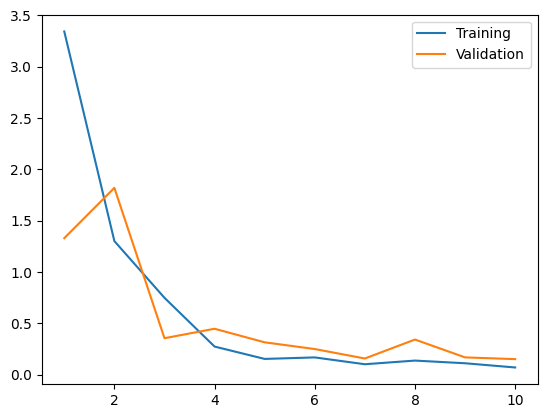

In [ ]:
loss_4_try1 = history4_try1.history['loss']
val_loss_4_try1 = history4_try1.history['val_loss']


epochs_4_try1 = range(1, len(loss_4_try1) + 1)

plt.plot(epochs_4_try1, loss_4_try1, label = 'Training')
plt.plot(epochs_4_try1, val_loss_4_try1, label = 'Validation')
plt.legend(loc = 'best')
plt.show()

In [ ]:
#RESNET50 MODEL USING ADAM OPTIMIZER

# Create the base model (ResNet50)
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights="imagenet")

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the custom architecture
model4_try2 = Sequential()
model4_try2.add(base_model)
model4_try2.add(Flatten())
model4_try2.add(Dense(1024, activation="relu"))
model4_try2.add(Dropout(0.5))
model4_try2.add(Dense(3, activation="softmax"))

# Compile the model with ADAM optimizer
model4_try2.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics=['accuracy'])

In [ ]:
check_point4_try2 = ModelCheckpoint(os.path.join(model_filepath, "trial4_try2.hdf5"), save_best_only=True, verbose =1)
history4_try2 = model4_try2.fit(train_generator2, validation_data=test_generator2, epochs=10, batch_size=batch_size, callbacks= [check_point4_try2, stopping])

Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 24.5316 - accuracy: 0.7862
Epoch 1: val_loss improved from inf to 8.82159, saving model to /content/drive/MyDrive/Breast Cancer Data/Model/trial4_try2.hdf5
45/45 [==============================] - 23s 404ms/step - loss: 24.5316 - accuracy: 0.7862 - val_loss: 8.8216 - val_accuracy: 0.8797
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 3.9392 - accuracy: 0.9088
Epoch 2: val_loss improved from 8.82159 to 2.95978, saving model to /content/drive/MyDrive/Breast Cancer Data/Model/trial4_try2.hdf5
45/45 [==============================] - 16s 362ms/step - loss: 3.9392 - accuracy: 0.9088 - val_loss: 2.9598 - val_accuracy: 0.8481
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 2.4727 - accuracy: 0.9318
Epoch 3: val_loss improved from 2.95978 to 2.65220, saving model to /content/drive/MyDrive/Breast Cancer Data/Model/trial4_try2.hdf5
45/45 [==============================] - 22s 499ms/step -

In [23]:
#RESNET50 MODEL USING ADAM OPTIMIZER

# Create the base model (ResNet50)
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights="imagenet")

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the custom architecture
model4_try3 = Sequential()
model4_try3.add(base_model)
model4_try3.add(Flatten())
model4_try3.add(Dense(1024, activation="relu"))
model4_try3.add(Dropout(0.5))
model4_try3.add(Dense(512, activation="relu"))
model4_try3.add(Dropout(0.5))
model4_try3.add(Dense(128, activation="relu"))
model4_try3.add(Dropout(0.5))
model4_try3.add(Dense(3, activation="softmax"))

# Compile the model with ADAM optimizer
model4_try3.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics=['accuracy'])

In [25]:
check_point4_try3 = ModelCheckpoint(os.path.join(model_filepath, "trial4_try3.hdf5"), save_best_only=True, verbose =1)
history4_try3 = model4_try3.fit(train_generator2, validation_data=test_generator2, epochs=10, batch_size=batch_size, callbacks= [check_point4_try3, stopping])

Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 0.9512 - accuracy: 0.8350
Epoch 1: val_loss improved from inf to 0.37363, saving model to /content/drive/MyDrive/Breast Cancer Data/Model/trial4_try3.hdf5
45/45 [==============================] - 28s 622ms/step - loss: 0.9512 - accuracy: 0.8350 - val_loss: 0.3736 - val_accuracy: 0.8671
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 0.9344 - accuracy: 0.8398
Epoch 2: val_loss improved from 0.37363 to 0.32728, saving model to /content/drive/MyDrive/Breast Cancer Data/Model/trial4_try3.hdf5
45/45 [==============================] - 16s 363ms/step - loss: 0.9344 - accuracy: 0.8398 - val_loss: 0.3273 - val_accuracy: 0.8671
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 0.7383 - accuracy: 0.8635
Epoch 3: val_loss did not improve from 0.32728
45/45 [==============================] - 8s 174ms/step - loss: 0.7383 - accuracy: 0.8635 - val_loss: 0.3566 - val_accuracy: 0.8671
Epoch 4/10
45/

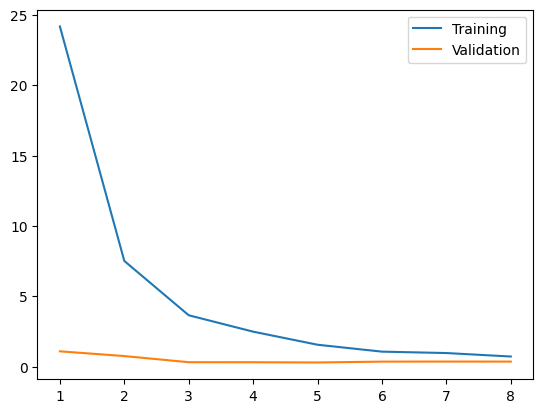

In [ ]:
loss_4_try3 = history4_try3.history['loss']
val_loss_4_try3 = history4_try3.history['val_loss']


epochs_4_try3 = range(1, len(loss_4_try3) + 1)

plt.plot(epochs_4_try3, loss_4_try3, label = 'Training')
plt.plot(epochs_4_try3, val_loss_4_try3, label = 'Validation')

plt.legend(loc = 'best')
plt.show()

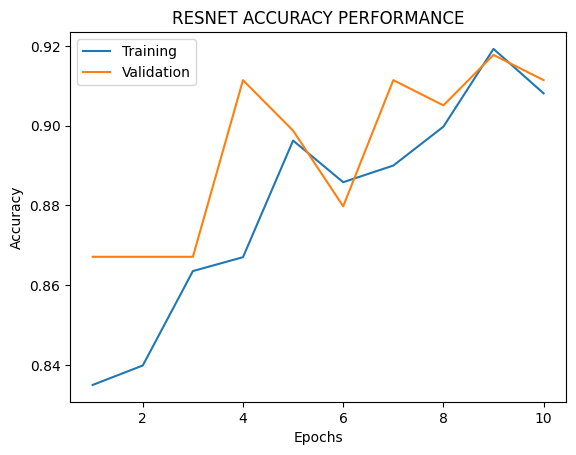

In [26]:
acc_4_try3 = history4_try3.history['accuracy']
val_accuracy_4_try3 = history4_try3.history['val_accuracy']


epochs_acc_4_try3 = range(1, len(acc_4_try3) + 1)

plt.plot(epochs_acc_4_try3, acc_4_try3, label = 'Training')
plt.plot(epochs_acc_4_try3, val_accuracy_4_try3, label = 'Validation')
plt.title('RESNET ACCURACY PERFORMANCE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()